# Digit Recognition with LeNet-5
Before running your code, make sure you are working on a GPU. If not, click Runtime -> Change runtime type -> Hardware accelerator (set this to GPU). 
## Import libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import iplot
%matplotlib inline

## Prepare data
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. More details can be found in http://yann.lecun.com/exdb/mnist/. We can use pytorch to download it from LeCun's website and get the train and test sets ready. 

In [2]:
data_train = MNIST(
  "./data/mnist",
  download=True,
  transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]),
)
data_test = MNIST(
  "./data/mnist",
  train=False,
  download=True,
  transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()]),
)
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=1024, num_workers=8)


In Pytorch, every image should be transformed into a tensor (C,H,W) where C is channel number, H is height and W is width. After putting images into minibatches, a minibatch shoude be a tensor (N,C,H,W) where N is batchsize.

In [3]:
print(f"Single sample size: {data_train[0][0].shape}")
minibatch = next(iter(data_train_loader))
images = minibatch[0]
labels = minibatch[1]
print(f"Batched sample size: {images.shape}")


Single sample size: torch.Size([1, 32, 32])
Batched sample size: torch.Size([256, 1, 32, 32])


Visualize first 4 images and their labels in the training set.


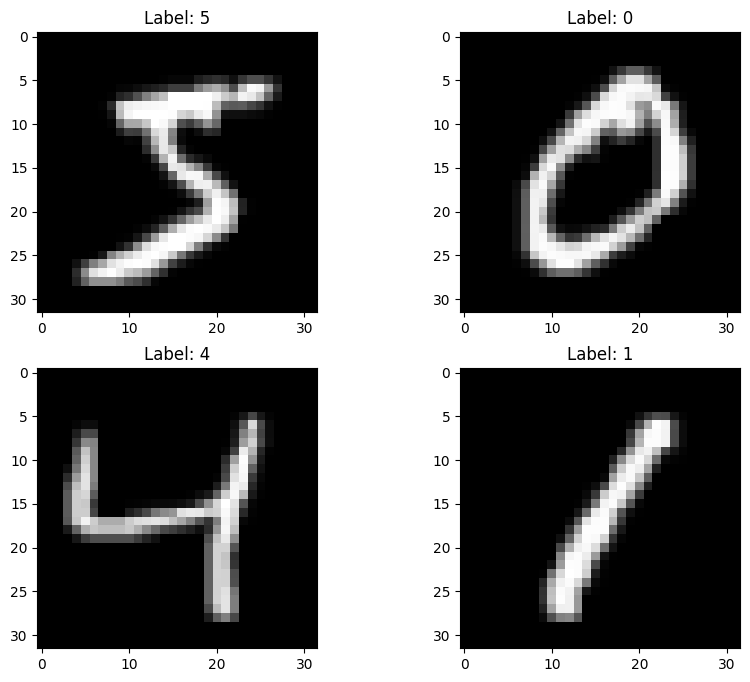

In [4]:
f = plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(data_train[0][0][0], cmap="gray")
plt.title(f"Label: {data_train[0][1]}")
plt.subplot(2, 2, 2)
plt.imshow(data_train[1][0][0], cmap="gray")
plt.title(f"Label: {data_train[1][1]}")
plt.subplot(2, 2, 3)
plt.imshow(data_train[2][0][0], cmap="gray")
plt.title(f"Label: {data_train[2][1]}")
plt.subplot(2, 2, 4)
plt.imshow(data_train[3][0][0], cmap="gray")
plt.title(f"Label: {data_train[3][1]}")
plt.show()


## LeNet-5
For a better performance, we change the activation function from Tanh to ReLU. We also change the original average pooling to max pooling. You can follow the description below to implement your LeNet-5 network.

In [5]:
class LeNet5(nn.Module):
  """
  Input - 1x32x32
  C1 - 6@28x28 (5x5 kernel)
  ReLU
  S2 - 6@14x14 (2x2 kernel, stride 2) MaxPool Subsampling
  C3 - 16@10x10 (5x5 kernel)
  ReLU
  S4 - 16@5x5 (2x2 kernel, stride 2) MaxPool Subsampling
  C5 - 120@1x1 (5x5 kernel)
  ReLU


  F6 - 120 (Input) & 84 (Output)
  ReLU
  F7 - 84 (Input) & 10 (Output)
  """

  def __init__(self):
    super(LeNet5, self).__init__()

    self.convnet = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5)),
      nn.ReLU(),
    )
    self.convnet.apply(self._weights_init_kaiming)
    self.fc = nn.Sequential(
      nn.Linear(in_features=120, out_features=84),
      nn.ReLU(),
      nn.Linear(in_features=84, out_features=10),
    )
    self.fc.apply(self._weights_init_kaiming)

  def forward(self, img):
    output = self.convnet(img)
    output = output.view(img.size(0), -1)
    output = self.fc(output)
    return output

  def _weights_init_kaiming(self, m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
      nn.init.kaiming_normal_(m.weight.data)
    elif classname.find("Linear") != -1:
      nn.init.kaiming_normal_(m.weight.data)
      nn.init.constant_(m.bias.data, 0.0)


In [6]:
lenet = LeNet5()
print(lenet.convnet)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (7): ReLU()
)


In [7]:
print(lenet.fc)

Sequential(
  (0): Linear(in_features=120, out_features=84, bias=True)
  (1): ReLU()
  (2): Linear(in_features=84, out_features=10, bias=True)
)


## Train your network
1. We have to define a loss function. In pytorch, ```nn.CrossEntropyLoss()``` combines the softmax and cross entropy loss function.

2. We also have to define an optimizer. Here, we use a SGD (Stochastic Gradient Descent) with an initial learning rate 0.002 and a momentum 0.9.

3. We need a scheduler which decrease the initial learning rate by 0.1 at the 20th epoch. 

4. We need to write a train function, in which we use optimizer to update parameters in out network to minimize the loss function.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lenet.parameters(), lr=0.002, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=20, gamma=0.1)


In [9]:
lenet = lenet.to("cuda")


def train(maxepoch: int):
  fig = go.FigureWidget(
    layout=go.Layout(
      title="Loss", xaxis_title="Batch", yaxis_title="Loss", yaxis_type="log"
    )
  )
  fig.add_trace(trace=go.Scatter(x=[0], y=[0]))

  track_loss = []

  lenet.train()
  for epoch in range(maxepoch):
    for i, (images, labels) in enumerate(data_train_loader):
      images = images.to("cuda")
      labels = labels.to("cuda")

      optimizer.zero_grad()

      output = lenet(images)

      loss = criterion(output, labels)

      if i % 30 == 0:
        continue
        print(f"Train - Epoch {epoch}, Batch: {i}, Loss: {loss.detach().cpu().item()}")

      track_loss.append(loss.detach().cpu().item())

      loss.backward()
      optimizer.step()
    scheduler.step()

    fig.update_traces(x= list(range(len(track_loss))), y= track_loss);

    fig.show()

  print("Finished.")


In [10]:
train(40)

Finished.


## Test your network

In [11]:
def test():
  lenet.eval()
  total_correct = 0
  for i, (images, labels) in enumerate(data_test_loader):
    images = images.to("cuda")
    labels = labels.to("cuda")
    output = lenet(images)
    pred = output.detach().max(1)[1]
    total_correct += pred.eq(labels.view_as(pred)).sum()
  print("Accuracy: %f" % (float(total_correct) / len(data_test)))


You are supposed to get an accuracy > 0.98 in the test set.

In [12]:
test()

Accuracy: 0.967300


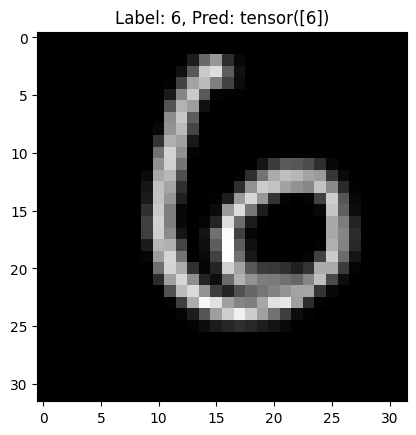

In [13]:
def visualize(idx):
  lenet.eval()
  image = data_test[idx][0].unsqueeze(0).to("cuda")
  label = data_test[idx][1]
  output = lenet(image)
  pred = output.detach().max(1)[1].cpu()
  plt.imshow(image[0][0].cpu(), cmap="gray")
  plt.title(f"Label: {label}, Pred: {pred}")


visualize(100)


In [14]:

fig = go.FigureWidget()
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[4, 5, 6]))
iplot(fig)

In [15]:
fig.add_trace(go.Scatter(x=[1, 2, 3], y=[-4, -5, 0]))
fig

FigureWidget({
    'data': [{'type': 'scatter', 'uid': '4b83920c-6ede-486f-bf96-8e945fe6bb13', 'x': [1, 2, 3], 'y': [4, 5, 6]},
             {'type': 'scatter', 'uid': '47b486fd-47ef-44e9-a247-4294e171d493', 'x': [1, 2, 3], 'y': [-4, -5, 0]}],
    'layout': {'template': '...'}
})

In [16]:
fig.update(dict(data={"y": [9, 4, 6]}))

FigureWidget({
    'data': [{'type': 'scatter', 'uid': '4b83920c-6ede-486f-bf96-8e945fe6bb13', 'x': [1, 2, 3], 'y': [4, 5, 6]},
             {'type': 'scatter', 'uid': '47b486fd-47ef-44e9-a247-4294e171d493', 'x': [1, 2, 3], 'y': [-4, -5, 0]}],
    'layout': {'template': '...'}
})

In [17]:
fig.data

(Scatter({
     'uid': '4b83920c-6ede-486f-bf96-8e945fe6bb13', 'x': [1, 2, 3], 'y': [4, 5, 6]
 }),
 Scatter({
     'uid': '47b486fd-47ef-44e9-a247-4294e171d493', 'x': [1, 2, 3], 'y': [-4, -5, 0]
 }))

In [18]:
fig.show()